In [1]:
pip install pandahouse

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/tljh/user/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandahouse as ph

In [10]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [11]:
que =  '''
    SELECT COUNT(*)
    FROM ldn_listings
'''

In [12]:
#df_listings = ph.read_clickhouse(query=que, connection = connection_default)
#df_listings.shape
ans = ph.read_clickhouse(query=que, connection = connection_default)
ans

,count()
0,85207


In [37]:
q = '''
    WITH filtered_data AS (
    SELECT
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_cleaned
    FROM
        ldn_listings
    ORDER BY
        id
    LIMIT 1000
)
SELECT
    room_type,
    quantileExact(0.75)(price_cleaned) AS price_75th_percentile
FROM
    filtered_data
GROUP BY
    room_type

'''

In [38]:
ans = ph.read_clickhouse(query=q, connection = connection_default)
ans

,room_type,price_75th_percentile
0,Hotel room,180.0
1,Private room,70.0
2,Shared room,166.0
3,Entire home/apt,160.0


In [48]:
q = '''
    WITH filtered_data AS (
    SELECT
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_cleaned,
        toFloat32OrNull(review_scores_rating) as rate
    FROM
        ldn_listings
    WHERE
        NOT isNull(review_scores_rating)
    ORDER BY
        id
    LIMIT 1000
)
SELECT
    room_type,
    AVG(price_cleaned) AS avg_price,
    AVG(rate) AS avg_rate
FROM
    filtered_data
GROUP BY
    room_type
'''
#ans['review_scores_rating']

In [49]:
ans = ph.read_clickhouse(query=q, connection = connection_default)
ans

,room_type,avg_price,avg_rate
0,Hotel room,134.000000,92.500000
1,Private room,66.820327,94.720096
2,Shared room,61.250000,90.000000
3,Entire home/apt,153.182844,93.663212


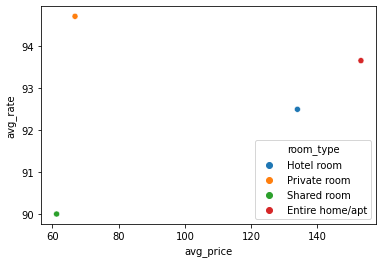

In [52]:
import seaborn as sns
sns.scatterplot(data = ans, hue = ans['room_type'], x = ans['avg_price'], y = ans['avg_rate'])

In [53]:
q = '''
SELECT
        DISTINCT host_id,
        host_verifications
    FROM
        ldn_listings
    WHERE
        experiences_offered != 'none'
'''

In [54]:
ans = ph.read_clickhouse(query=q, connection = connection_default)
ans

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [55]:
ans['host_verifications'] = ans['host_verifications'].apply(lambda s: s.strip('[]').replace("'", "").split(', '))
ans.head()

,host_id,host_verifications
0,54730,"[email, phone, facebook, reviews, offline_gove..."
1,60302,"[email, phone, reviews, jumio, government_id]"
2,67915,"[email, phone, jumio, selfie, government_id, i..."
3,167107,"[email, phone, manual_offline, jumio, offline_..."
4,103583,"[email, phone, reviews, offline_government_id,..."


In [56]:
ans_exploded = ans.explode('host_verifications')
ans_exploded['host_verifications'].value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

In [59]:
q = '''
    SELECT
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS corr_price
    FROM
        ldn_listings
    WHERE
        experiences_offered != 'none'
'''

In [60]:
ans = ph.read_clickhouse(query=q, connection = connection_default)
ans

,room_type,corr_price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


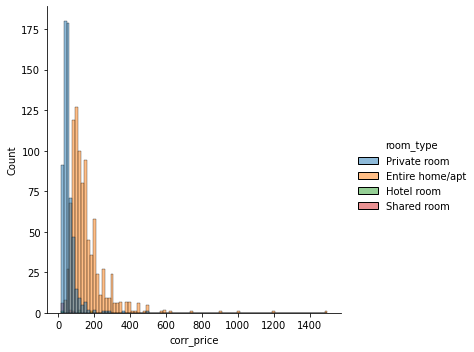

In [65]:
sns.displot(data = ans, hue = 'room_type', x = 'corr_price')

In [69]:
ans['log_price'] = np.log10(ans['corr_price'])

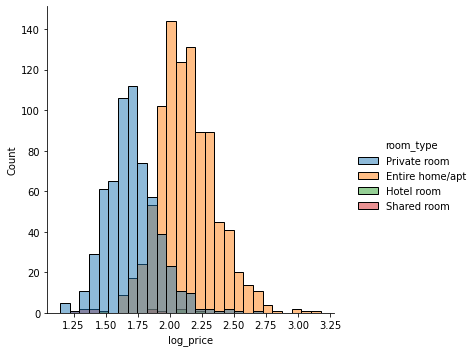

In [71]:
import numpy as np
sns.displot(data = ans, hue = 'room_type', x = 'log_price')